# Sentiment analysis using LinearSVM, SpaCy

In [175]:
import pandas as pd
import spacy
from spacy import displacy
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [30]:
nlp = spacy.load('en_core_web_sm')

In [33]:
data_yelp = pd.read_csv('datasets/yelp_labelled.txt', sep='\t', header = None)

In [34]:
data_yelp.head()

,0,1
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [35]:
columns_name = ['Review', 'Sentiment']
data_yelp.columns = columns_name

In [36]:
data_yelp.head()

,Review,Sentiment
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [37]:
data_yelp.shape

(1000, 2)

In [38]:
data_amazon = pd.read_csv('datasets/amazon_cells_labelled.txt', sep = '\t', header = None)
data_amazon.columns = columns_name

In [39]:
data_amazon.head()

,Review,Sentiment
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


In [40]:
data_amazon.shape

(1000, 2)

In [41]:
data_imdb = pd.read_csv('datasets/imdb_labelled.txt', sep = '\t', header = None)

In [42]:
data_imdb.columns = columns_name

In [43]:
data_imdb.shape

(748, 2)

In [44]:
data_imdb.head()

,Review,Sentiment
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


In [45]:
data = data_yelp.append([data_amazon, data_imdb], ignore_index=True)

In [46]:
data.shape

(2748, 2)

In [47]:
data.head()

,Review,Sentiment
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [48]:
data['Sentiment'].value_counts()

1    1386
0    1362
Name: Sentiment, dtype: int64

In [49]:
data.isnull().sum()

Review       0
Sentiment    0
dtype: int64

###  Data Preprocessing

In [50]:
import string

In [51]:
punct = string.punctuation

In [52]:
punct

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [152]:
# Remove 'not' from stopwords

stopwords = list(STOP_WORDS)
stopwords.remove('not')
stopwords.remove('n\'t')
stopwords.remove('n‘t')
stopwords.remove('n’t')

In [89]:
def data_cleaning(sentence):
    doc = nlp(sentence)
    
    tokens = []
    for token in doc:
        if token.lemma_ != "-PRON-":
            temp = token.lemma_.lower().strip()
        else:
            temp = token.lower_
        tokens.append(temp)
    
    cleaned_tokens = []
    for token in tokens:
        if token not in stopwords and token not in punct:
            cleaned_tokens.append(token)
    return cleaned_tokens

In [90]:
data_cleaning("    Hello how are you. Like this video")

['hello', 'like', 'video']

### Vectorization Feature Engineering (TF-IDF) 

In [160]:
from sklearn.svm import LinearSVC

In [161]:
tfidf = TfidfVectorizer(tokenizer = data_cleaning)
classifier = LinearSVC(C=0.1)

In [162]:
X = data['Review']
y = data['Sentiment']

In [163]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [164]:
X_train.shape, X_test.shape

((2198,), (550,))

In [165]:
clf = Pipeline([('tf_idf', tfidf), ('clf', classifier)])

In [166]:
%%time
clf.fit(X_train, y_train)

Wall time: 14.8 s


Pipeline(memory=None,
         steps=[('tf_idf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function data_cleaning at 0x0000012D66D66B70>,
                                 use_idf=True, vocabulary=None)),
                ('clf',
                 LinearSVC(C=0.1, class_weight=None, dual=True,
                           fit_intercept

In [167]:
y_pred = clf.predict(X_test)

In [178]:
from sklearn.metrics import accuracy_score
round(accuracy_score(y_test, y_pred),3)

0.813

In [168]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.79      0.81       285
           1       0.79      0.84      0.81       265

    accuracy                           0.81       550
   macro avg       0.81      0.81      0.81       550
weighted avg       0.81      0.81      0.81       550



Test confusion matrix
[[225  60]
 [ 43 222]]


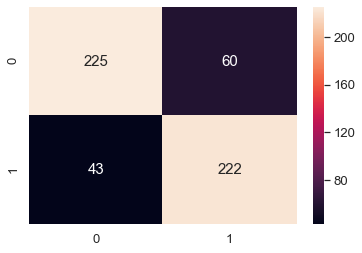

In [176]:
print("Test confusion matrix")
cm = confusion_matrix(y_test, y_pred)
print(cm)

sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, annot_kws={"size": 15}, fmt='g')

In [170]:
clf.predict(['Wow, this is amazing lesson'])

array([1], dtype=int64)

In [171]:
clf.predict(['Wow, this sucks'])

array([0], dtype=int64)

In [172]:
clf.predict(['Worth of watching it. Please like it'])

array([1], dtype=int64)

In [173]:
clf.predict(['Hated it.'])

array([0], dtype=int64)

In [174]:
clf.predict(['not good'])

array([0], dtype=int64)